In [1]:
import scipy
from scipy.interpolate import *
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pandas as pd
from pandas import Series, DataFrame

In [2]:
def convex_smoothing_spline(val0, val1, pullpt=0.2, pullval=0.2, k=3, num_c=10, midpt=0.5, midval=0, squash_edge=0.2, lam=1.0):
    """Fits a convex smoothing spline to the data (x, y).

    Args:
        x: Array of x-coordinates.
        y: Array of y-coordinates.
        lam: Smoothing parameter (higher values lead to smoother curves).

    Returns:
        BSpline object representing the convex smoothing spline.
    """

    # n = len(x)

    # Construct B-spline basis
#     t = np.linspace(0, 1, n + k + 1)
#     b_spline = BSpline(t, np.eye(n + k + 1), k)
    
    #num_c = 5+k+1
    # k = 3
    t = np.linspace(0, 1, num_c)
    b_spline = BSpline(t, np.eye(num_c), k)

    # Create CVXPY variables
    # coeffs = cp.Variable(n + k + 1)
    coeffs = cp.Variable(num_c)


    x = np.linspace(0, 1, 20)
    x_ends = np.concatenate([np.linspace(0, squash_edge, 20), np.linspace(1-squash_edge, 1, 20)])
    x_mids = np.linspace(squash_edge, 1-squash_edge, 40)
    
    xpulls = np.array([pullpt, 2*midpt-pullpt])
    ypulls = pullval * np.array([val0, val1])
    
    # Define the objective function
    # objective = cp.sum_squares(b_spline(x) @ coeffs - y) + lam * cp.sum_squares(b_spline(x, 2) @ coeffs)
#     objective = lam * cp.sum_squares(b_spline(x_ends, 1) @ coeffs) \
#               + cp.sum_squares(b_spline(x_mids, 1) @ coeffs)
    # objective = cp.mean(b_spline(x, 2) @ coeffs) + lam * cp.sum_squares(b_spline(xpulls) @ coeffs - ypulls)
    objective = cp.sum_squares(b_spline(xpulls) @ coeffs - ypulls)

    # Define the constraints for convexity
    constraints = [b_spline(x, 2) @ coeffs >= 0,
                   b_spline(midpt, 1) @ coeffs == 0,
                   b_spline(midpt) @ coeffs == midval,
                   b_spline(0) @ coeffs == val0,
                   b_spline(1) @ coeffs == val1,
                  ]

    # Solve the optimization problem
    problem = cp.Problem(cp.Minimize(objective), constraints)
    problem.solve()

    return BSpline(t, coeffs.value, k)

In [3]:
def util_one_firm(tval, mu_m, rho):
    s = np.square(tval) + np.square(1-tval) + 2*rho*tval*(1-tval)
    return 1/4*np.square(mu_m)/s

In [4]:
def util_middle(t, spline, val0, val1, rho):
    mu_t = spline(t)
    b = (val1 - val0)/2
    utils = np.square(mu_t - b*(1-rho)*(t-0.5))/(2*(1+rho)) + np.square(b)*(1-rho)/8
    return utils

In [5]:
def util_middle_general(t, spline, val0, val1, rho, f):
    mu_1, mu_0 = val1, val0
    mu_m = spline(t)
    
    tmp = np.sqrt(np.square(2*f-1) + 4*rho*rho*f*(1-f))
    xplus, xminus = (1-2*f+tmp)/(2*rho*(1-f)), (1-2*f-tmp)/(2*rho*(1-f))
    Zplus, Zminus = np.sqrt(f+(1-f)*np.square(xplus)), np.sqrt(f+(1-f)*np.square(xminus))
    gamma_plus, gamma_minus = (t + (1-t)*xplus)/Zplus, (t + (1-t)*xminus)/Zminus
    
    nuplus, numinus = (f+(1-f)*xplus)/Zplus, (f+(1-f)*xminus)/Zminus
    etaplus, etaminus = (f*mu_1+(1-f)*xplus*mu_0)/Zplus, (f*mu_1+(1-f)*xminus*mu_0)/Zminus
    phiplus, phiminus = (f+(1-f)*rho*xplus), (f+(1-f)*rho*xminus)
    zeta = phiminus*nuplus*etaminus - phiplus*numinus*etaplus
    pred_util = np.square(nuplus*mu_m-gamma_minus*zeta)/(4*phiplus)\
              + np.square(numinus*mu_m+gamma_plus*zeta)/(4*phiminus)
    
    return pred_util

In [6]:
def do_plot(rho, val0, val1, lam, num_c, midpt, pullpt, f=0.5, xmin=None, xmax=None, ymin=None, ymax=None,
            only_mu_plot=False, only_util_plot=False, savefile=None, check_onefirm_utils=False, fontsize=18):
    x_new = np.linspace(0, 1, 100)
    b = (val1-val0)/2

    colors = ['r', 'g', 'blue', 'black', 'brown']
    
    if only_mu_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
        ax2 = None
    elif only_util_plot:
        fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
        ax1 = None
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
        
    for i, pullval in enumerate(np.linspace(0.05, 0.3, 5)):
        spline = convex_smoothing_spline(num_c=num_c, val0=val0, val1=val1, midpt=midpt, pullpt=pullpt, pullval=pullval, lam=lam)
        y_new = spline(x_new)
        term2 = b*(1-rho)*(x_new-0.5)
        #utils = util_middle(t=x_new, spline=spline, val0=val0, val1=val1, rho=rho)
        
        if check_onefirm_utils:
            one_firm_utils = util_one_firm(tval=x_new, mu_m=y_new, rho=rho)
            deriv1 = Series(one_firm_utils)-Series(one_firm_utils).shift(1)
            minima = deriv1[(deriv1>0) & (deriv1.shift(1)<=0)].index.values
            print('i=', i, 'Util of one firm without trading: Number of minima == 1?', len(minima)==1, x_new[minima] if len(minima)>1 else '')        
        
        utils = util_middle_general(t=x_new, spline=spline, val0=val0, val1=val1, rho=rho, f=f)
        deriv1 = Series(utils)-Series(utils).shift(1)
        minima = deriv1[(deriv1>0) & (deriv1.shift(1)<=0)].index.values
        if len(minima)==2:
            this_max_util_in_minima = max(utils[minima[0]:minima[1]])
            if ymax is None or this_max_util_in_minima > ymax:
                ymax = this_max_util_in_minima
            if xmin is None or x_new[minima[0]]<xmin:
                xmin = x_new[minima[0]]
            if xmax is None or x_new[minima[1]]>xmax:
                xmax = x_new[minima[1]]
            ymin = min(utils)

        if ax1 is not None:
            ax1.plot(x_new, y_new, '-', color=colors[i], label=f'pullval={pullval:3.3f}')
            ax1.plot([0,1], [0,0], ':', color='black')
            ax1.plot([midpt, midpt], [-0.05, np.max(y_new)], ':', color='black')
#             ax1.plot(x_new, term2, ':')

        if ax2 is not None:
            if len(minima)==2:
                ax2.plot(x_new[:minima[0]], utils[:minima[0]], ':', color=colors[i])
                ax2.plot(x_new[minima[0]:minima[1]], utils[minima[0]:minima[1]], '-', color=colors[i], label=f'pullval={pullval:3.3f}')
                ax2.plot(x_new[minima[1]:], utils[minima[1]:], ':', color=colors[i])
            else:
                ax2.plot(x_new, utils, ':', color=colors[i], label=f'pullval={pullval:3.3f}')
    
    if ax2 is not None:
        if ymax is not None:
            ax2.set_ylim(max(0, 0.9*ymin), ymax*1.1)
        if xmax is not None:
            ax2.set_xlim(max(0, 0.9*xmin), min(1, 1.1*xmax))

    if ax1 is not None:
        ax1.set_xlabel(r'Industry tilt $\theta$', fontsize=fontsize)
        ax1.set_ylabel(r'Expected payoff $\mu(\theta)$', fontsize=fontsize)
    if ax2 is not None:
        ax2.set_xlabel(r"Firm's industry tilt", fontsize=fontsize)
        ax2.set_ylabel(r"Firm's utility", fontsize=fontsize)
    
    if savefile is not None:
        fig.savefig(savefile, bbox_inches='tight')
        
#     ax1.legend()
#     ax2.legend()

### Varying f

i= 0 Util of one firm without trading: Number of minima == 1? True
i= 1 Util of one firm without trading: Number of minima == 1? True
i= 2 Util of one firm without trading: Number of minima == 1? True
i= 3 Util of one firm without trading: Number of minima == 1? True
i= 4 Util of one firm without trading: Number of minima == 1? True


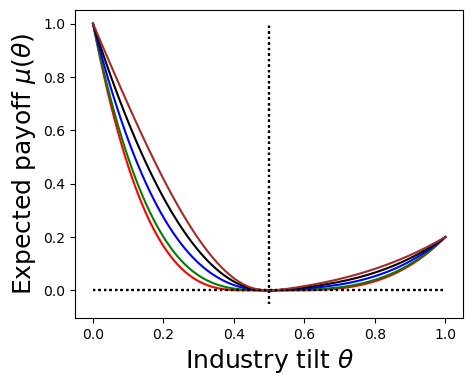

In [17]:
rho, val0, val1 = -0.9, 1, 0.2
lam, num_c , midpt = 1e5, 10, 0.5
pullpt = 0.5 * midpt
do_plot(rho=rho, val0=val0, val1=val1, lam=lam, num_c=num_c, midpt=midpt, pullpt=pullpt, f=0.1, xmin=0, xmax=0.5,
        only_mu_plot=True, check_onefirm_utils=True, savefile='figs/vary_f_mu.png')

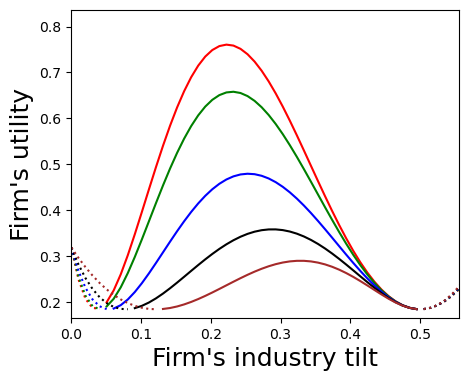

In [482]:
do_plot(rho=rho, val0=val0, val1=val1, lam=lam, num_c=num_c, midpt=midpt, pullpt=pullpt, f=0.1, xmin=0, xmax=0.5,
        only_util_plot=True, savefile='figs/vary_f_dot1.png')

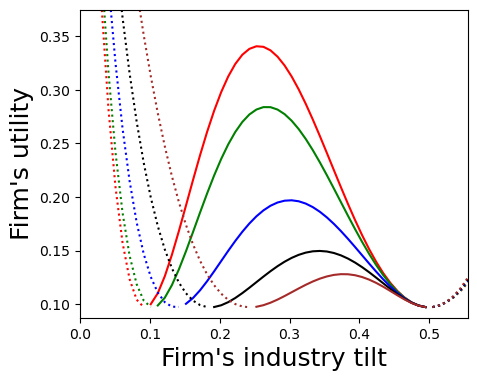

In [483]:
do_plot(rho=rho, val0=val0, val1=val1, lam=lam, num_c=num_c, midpt=midpt, pullpt=pullpt, f=0.3, xmin=0, xmax=0.5,
        only_util_plot=True, savefile='figs/vary_f_dot3.png')

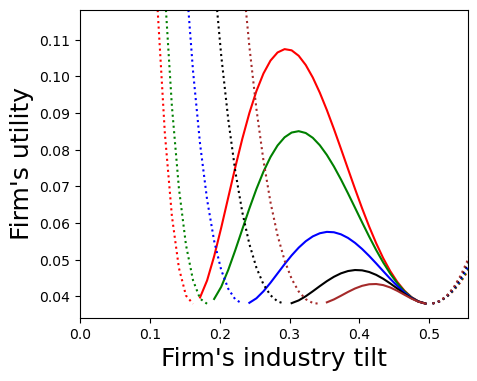

In [484]:
do_plot(rho=rho, val0=val0, val1=val1, lam=lam, num_c=num_c, midpt=midpt, pullpt=pullpt, f=0.5, xmin=0, xmax=0.5,
       only_util_plot=True, savefile='figs/vary_f_dot5.png')

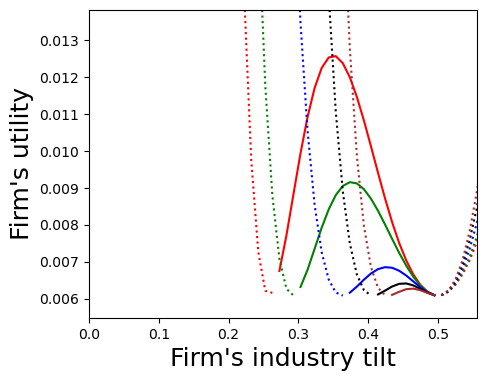

In [485]:
do_plot(rho=rho, val0=val0, val1=val1, lam=lam, num_c=num_c, midpt=midpt, pullpt=pullpt, f=0.7, xmin=0, xmax=0.5,
       only_util_plot=True, savefile='figs/vary_f_dot7')

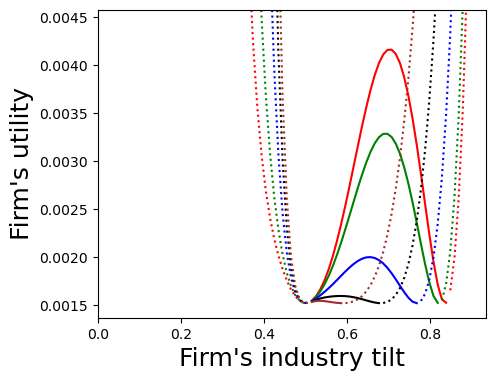

In [486]:
do_plot(rho=rho, val0=val0, val1=val1, lam=lam, num_c=num_c, midpt=midpt, pullpt=pullpt, f=0.9, xmin=0, xmax=0.5,
       only_util_plot=True, savefile='figs/vary_f_dot9')

### Varying midpt

i= 0 Util of one firm without trading: Number of minima == 1? False [0.43434343 0.50505051 0.58585859]
i= 1 Util of one firm without trading: Number of minima == 1? False [0.45454545 0.50505051 0.58585859]
i= 2 Util of one firm without trading: Number of minima == 1? False [0.47474747 0.50505051 0.57575758]
i= 3 Util of one firm without trading: Number of minima == 1? True 
i= 4 Util of one firm without trading: Number of minima == 1? True 


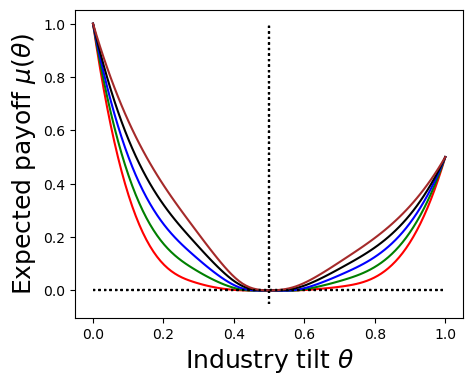

In [22]:
rho, val0, val1 = -0.5, 1, 0.5
lam, num_c = 1e5, 15
f = 0.5

midpt = 0.5
pullpt = 0.5 * midpt
do_plot(rho=rho, val0=val0, val1=val1, lam=lam, num_c=num_c, midpt=midpt, pullpt=pullpt, f=f, xmin=0.1, xmax=0.5,
        only_mu_plot=True, check_onefirm_utils=True, savefile=None) #'figs/vary_mid_mu_dot5')

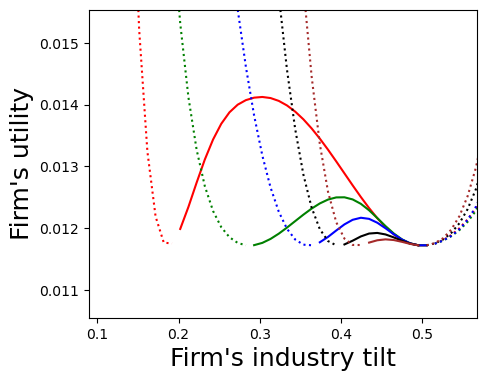

In [506]:
do_plot(rho=rho, val0=val0, val1=val1, lam=lam, num_c=num_c, midpt=midpt, pullpt=pullpt, f=f, xmin=0.1, xmax=0.5,
        only_util_plot=True, savefile='figs/vary_mid_util_dot5')

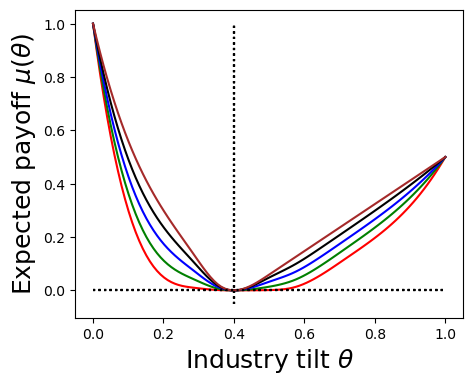

In [507]:
midpt = 0.4
pullpt = 0.5 * midpt
do_plot(rho=rho, val0=val0, val1=val1, lam=lam, num_c=num_c, midpt=midpt, pullpt=pullpt, f=f, xmin=0.1, xmax=0.5,
       only_mu_plot=True, savefile='figs/vary_mid_mu_dot4')

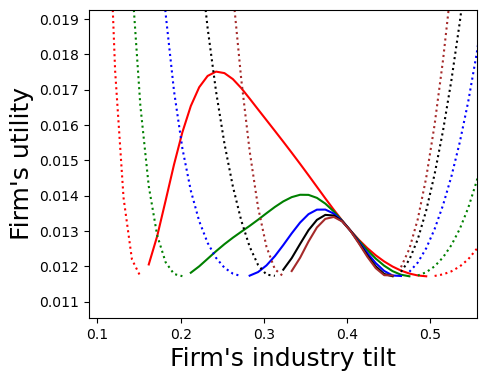

In [508]:
do_plot(rho=rho, val0=val0, val1=val1, lam=lam, num_c=num_c, midpt=midpt, pullpt=pullpt, f=f, xmin=0.1, xmax=0.5,
       only_util_plot=True, savefile='figs/vary_mid_util_dot4')

i= 0 Util of one firm without trading: Number of minima == 1? False [0.21212121 0.31313131 0.35353535]
i= 1 Util of one firm without trading: Number of minima == 1? True 
i= 2 Util of one firm without trading: Number of minima == 1? True 
i= 3 Util of one firm without trading: Number of minima == 1? True 
i= 4 Util of one firm without trading: Number of minima == 1? True 


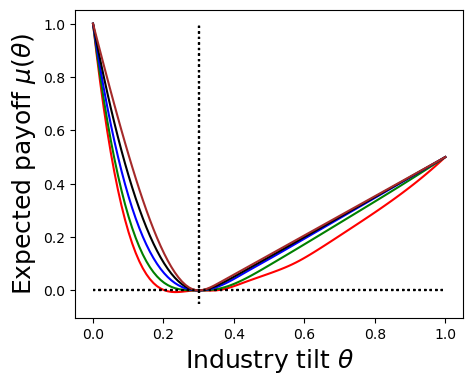

In [23]:
midpt = 0.3
pullpt = 0.5 * midpt
do_plot(rho=rho, val0=val0, val1=val1, lam=lam, num_c=num_c, midpt=midpt, pullpt=pullpt, f=f, xmin=0.1, xmax=0.5,
       only_mu_plot=True, check_onefirm_utils=True, savefile=None) #'figs/vary_mid_mu_dot3')

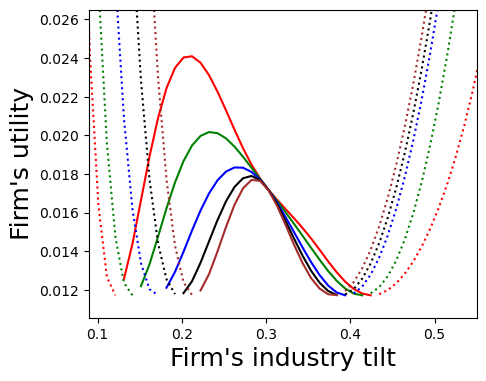

In [510]:
do_plot(rho=rho, val0=val0, val1=val1, lam=lam, num_c=num_c, midpt=midpt, pullpt=pullpt, f=f, xmin=0.1, xmax=0.5,
       only_util_plot=True, savefile='figs/vary_mid_util_dot3')

---


In [33]:
from functools import partial

def base_f(t, pwr, mid=0.6):
    return np.power(t-mid, pwr) / np.power(-mid, pwr)

all_t = np.linspace(0,1,100)

mid, rho = 0.55, -0.9
poly_degrees = [2, 4, 6]

# mid, rho = 0.55, -0.95
# poly_degrees = [2,4,6]
all_mus, all_utils, one_firm_utils = {}, {}, {}
for i in poly_degrees:
    all_mus[i] = base_f(all_t, pwr=i, mid=mid)
    b = 0.5*(base_f(1, pwr=i, mid=mid)-base_f(0, pwr=i, mid=mid))
    all_utils[i] = np.square(all_mus[i] - b*(1-rho)*(all_t-0.5))/(2*(1+rho)) + np.square(b)*(1-rho)/8
    one_firm_utils[i] = util_one_firm(tval=all_t, mu_m=all_mus[i], rho=rho)

In [39]:
for i in poly_degrees:
    utils = one_firm_utils[i]
    deriv1 = Series(utils)-Series(utils).shift(1)
    minima = deriv1[(deriv1>0) & (deriv1.shift(1)<=0)].index.values
    print('Util of one firm without trading: Number of minima == 1?', len(minima)==1, 'at', np.round(minima, 2))

Util of one firm without trading: Number of minima == 1? True at [55]
Util of one firm without trading: Number of minima == 1? True at [55]
Util of one firm without trading: Number of minima == 1? True at [55]


In [35]:
fontsize, legend_fontsize = 18, 14
markers = ['s', 'o', 'v']
colors = ['blue', 'red', 'black']

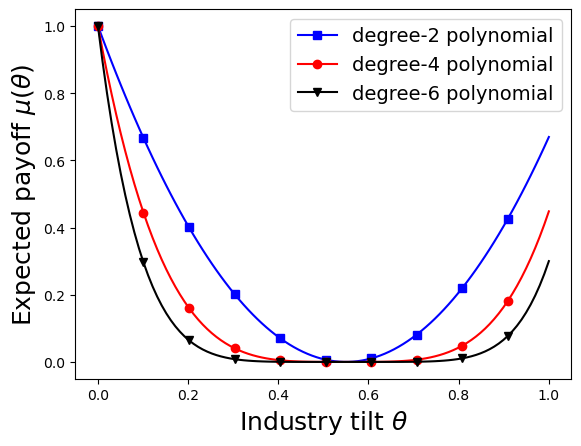

In [36]:
for idx, i in enumerate(poly_degrees):
    plt.plot(all_t, all_mus[i], marker=markers[idx], color=colors[idx], markevery=10, label=f'degree-{i} polynomial')
plt.xlabel(r'Industry tilt $\theta$', fontsize=fontsize)
plt.ylabel(r'Expected payoff $\mu(\theta)$', fontsize=fontsize)
plt.legend(fontsize=legend_fontsize)
# fig = plt.gcf()
# fig.savefig('figs/polynomial_mu.png', bbox_inches='tight')

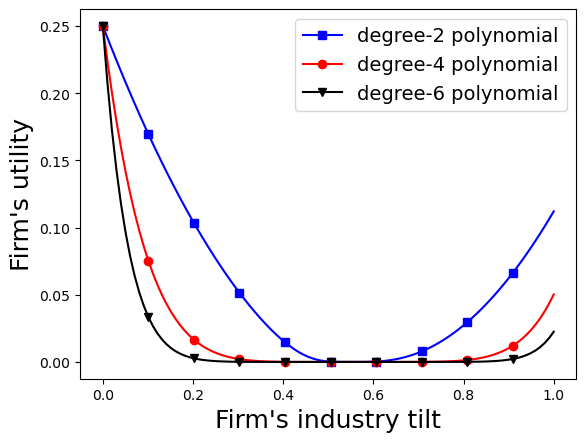

In [37]:
for idx, i in enumerate(poly_degrees):
    plt.plot(all_t, one_firm_utils[i], marker=markers[idx], color=colors[idx], markevery=10, label=f'degree-{i} polynomial')
plt.xlabel(r"Firm's industry tilt", fontsize=fontsize)
plt.ylabel(r"Firm's utility", fontsize=fontsize)
plt.legend(fontsize=legend_fontsize)
# fig = plt.gcf()
# fig.savefig('figs/polynomial_util_one_firm.png', bbox_inches='tight')

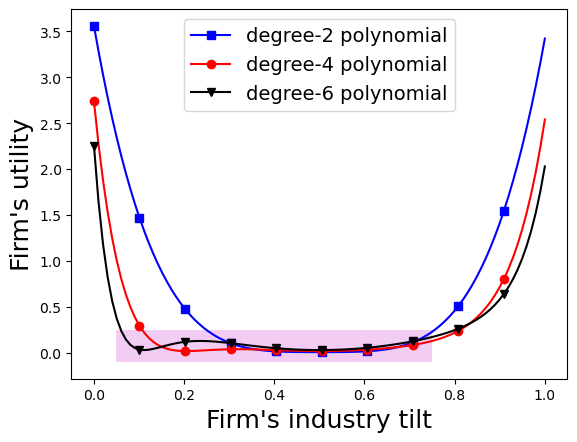

In [38]:
for idx, i in enumerate(poly_degrees):
    plt.plot(all_t, all_utils[i], marker=markers[idx], color=colors[idx], markevery=10, label=f'degree-{i} polynomial')
plt.xlabel(r"Firm's industry tilt", fontsize=fontsize)
plt.ylabel(r"Firm's utility", fontsize=fontsize)
plt.legend(fontsize=legend_fontsize)
plt.gca().add_patch(plt.Rectangle((0.05,-0.1), 0.7, 0.35, ls='none', ec='none', fc='m', alpha=0.2))
# fig = plt.gcf()
# fig.savefig('figs/polynomial_util.png', bbox_inches='tight')

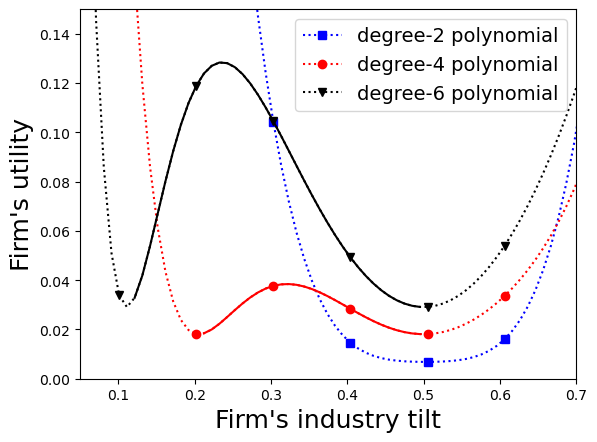

In [98]:
for idx, i in enumerate(poly_degrees):
    deriv1 = Series(all_utils[i])-Series(all_utils[i]).shift(1)
    minima = deriv1[(deriv1>0) & (deriv1.shift(1)<=0)].index.values
    plt.plot(all_t, all_utils[i], linestyle=':', marker=markers[idx], color=colors[idx],
             markevery=10, label=f'degree-{i} polynomial')
    if len(minima)==2:
        plt.plot(all_t[minima[0]:minima[1]], all_utils[i][minima[0]:minima[1]], color=colors[idx])
plt.xlim((0.05, 0.7))
plt.ylim((0, 0.15))
plt.xlabel(r"Firm's industry tilt", fontsize=fontsize)
plt.ylabel(r"Firm's utility", fontsize=fontsize)
plt.legend(fontsize=legend_fontsize)
fig = plt.gcf()
fig.savefig('figs/polynomial_util_magnified.png', bbox_inches='tight')